## Libraries, Hyper-parameters, Varibles, and Data

In [ ]:
%matplotlib inline

In [ ]:
# Imports
import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications.xception import Xception
from tensorflow.keras.utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras

In [ ]:
# Output files
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_PLOT_FILE = "model_plot.png"
MODEL_FILE = "model.keras"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
ROC_PLOT_FILE = "roc.png"
KAGGLE_SUBMISSION_FILE = "kaggle_submission.csv"

In [ ]:
# Hyperparams
SAMPLE_COUNT = 85000
TRAINING_RATIO = 0.9
IMAGE_SIZE = 96
EPOCHS = 10
BATCH_SIZE = 192
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

In [ ]:
# Imports
import os
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from skimage.io import imread
import shutil

# Constants
input_dir = './'  # Root folder as seen in the image
training_dir = os.path.join(input_dir, 'train/')
data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir, '*.tif'))})
data_frame['id'] = data_frame.path.map(lambda x: os.path.basename(x).split('.')[0])  # Updated for new directory hierarchy
labels = pd.read_csv(os.path.join(input_dir, 'train_labels.csv'))
data_frame = data_frame.merge(labels, on='id')

# Constants for sampling
SAMPLE_COUNT = 1000  # Replace with the desired number of samples for each class
TRAINING_RATIO = 0.8  # Replace with the desired training-to-validation split ratio

# Sampling negatives and positives
negatives = data_frame[data_frame.label == 0].sample(SAMPLE_COUNT)
positives = data_frame[data_frame.label == 1].sample(SAMPLE_COUNT)
data_frame = pd.concat([negatives, positives]).reset_index()
data_frame = data_frame[['path', 'id', 'label']]
data_frame['image'] = data_frame['path'].map(imread)

# Define paths for training and validation
training_path = './training'
validation_path = './validation'

# Create folders for training and validation
for folder in [training_path, validation_path]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        os.makedirs(path, exist_ok=True)

# Split data into training and validation sets
training, validation = train_test_split(data_frame, train_size=TRAINING_RATIO, stratify=data_frame['label'])

data_frame.set_index('id', inplace=True)

# Copy images to respective folders
for images_and_path in [(training, training_path), (validation, validation_path)]:
    images = images_and_path[0]
    path = images_and_path[1]
    for image in images['id'].values:
        file_name = image + '.tif'
        label = str(data_frame.loc[image, 'label'])
        destination = os.path.join(path, label, file_name)
        if not os.path.exists(destination):
            source = os.path.join(training_dir, file_name)
            shutil.copyfile(source, destination)


In [ ]:
# Data augmentation
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=180,
                                             zoom_range=0.4, 
                                             width_shift_range=0.3,
                                             height_shift_range=0.3,
                                             shear_range=0.3,
                                             channel_shift_range=0.3)

In [ ]:
# Data generation
training_generator = training_data_generator.flow_from_directory(training_path,
                                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                 batch_size=BATCH_SIZE,
                                                                 class_mode='binary')
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                              target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                              batch_size=BATCH_SIZE,
                                                                              class_mode='binary')
testing_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                           target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                           batch_size=BATCH_SIZE,
                                                                           class_mode='binary',
                                                                           shuffle=False)

Found 6325 images belonging to 2 classes.
Found 1592 images belonging to 2 classes.
Found 1592 images belonging to 2 classes.


## Traditional ML without Feature Extraction


This section covers traditional machine learning methods applied directly to raw data without any feature extraction.

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
from skimage.io import imread
from skimage.transform import resize  # Import resize function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_images(data_frame):
    images = []
    labels = []
    
    for index, row in data_frame.iterrows():
        image = imread(row['path'])
        image = resize(image, (IMAGE_SIZE, IMAGE_SIZE))  # Resize images
        images.append(image.flatten())  # Flatten image
        labels.append(row['label'])
    
    return np.array(images), np.array(labels)

# Preprocess data
X, y = preprocess_images(data_frame)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Adjust n_components as needed
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# SVM Model
svm_model = SVC()
svm_model.fit(X_train_pca, y_train)
svm_predictions = svm_model.predict(X_val_pca)
print(f"SVM Accuracy: {accuracy_score(y_val, svm_predictions) * 100:.2f}%")

# KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_pca, y_train)
knn_predictions = knn_model.predict(X_val_pca)
print(f"KNN Accuracy: {accuracy_score(y_val, knn_predictions) * 100:.2f}%")

# Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_pca, y_train)
logistic_predictions = logistic_model.predict(X_val_pca)
print(f"Logistic Regression Accuracy: {accuracy_score(y_val, logistic_predictions) * 100:.2f}%")


SVM Accuracy: 69.00%
KNN Accuracy: 65.00%
Logistic Regression Accuracy: 71.75%


## Traditional ML and Traditional Neural Network with Feature Extraction


This section involves applying traditional machine learning techniques on data after performing feature extraction.

In [ ]:
from keras.applications import VGG19
from keras.models import Model

# Load VGG19 model without the top layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Create a new model that outputs the features from the last convolutional layer
model = Model(inputs=base_model.input, outputs=base_model.output)


In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# Create a data generator for training data
training_datagen = ImageDataGenerator(rescale=1./255)
training_generator = training_datagen.flow_from_directory(
    training_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for consistent ordering of predictions
)

# Extract features from training data
features_train = model.predict(training_generator)


Found 6325 images belonging to 2 classes.


c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 294s 9s/step


In [ ]:
# Get labels from the generator
labels_train = training_generator.classes  # This will give you the true labels


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense

# Flatten the features if necessary (depends on your classifier)
features_train_flattened = features_train.reshape(features_train.shape[0], -1)

# SVM Classifier
svm_model = SVC()
svm_model.fit(features_train_flattened, labels_train)
svm_predictions = svm_model.predict(features_train_flattened)
print(f"SVM Accuracy: {accuracy_score(labels_train, svm_predictions) * 100:.2f}%")

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(features_train_flattened, labels_train)
rf_predictions = rf_model.predict(features_train_flattened)
print(f"Random Forest Accuracy: {accuracy_score(labels_train, rf_predictions) * 100:.2f}%")

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(features_train_flattened, labels_train)
gb_predictions = gb_model.predict(features_train_flattened)
print(f"Gradient Boosting Accuracy: {accuracy_score(labels_train, gb_predictions) * 100:.2f}%")

# Neural Network Classifier
nn_model = Sequential()
nn_model.add(Dense(512, activation='relu', input_shape=(features_train_flattened.shape[1],)))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the extracted features
nn_model.fit(features_train_flattened, labels_train, epochs=10, batch_size=32)

# Predict on training set
nn_predictions = (nn_model.predict(features_train_flattened) > 0.5).astype("int32")
print(f"Neural Network Accuracy: {accuracy_score(labels_train, nn_predictions) * 100:.2f}%")


SVM Accuracy: 84.14%
Random Forest Accuracy: 100.00%
Gradient Boosting Accuracy: 88.93%
Epoch 1/10


c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


198/198 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.7477 - loss: 0.5541
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8187 - loss: 0.4002
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8375 - loss: 0.3770
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8577 - loss: 0.3193
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8674 - loss: 0.3076
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8767 - loss: 0.2867
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8791 - loss: 0.2750
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8877 - loss: 0.2592
Epoch 9/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8971 - loss: 0.2416
Epoch 10/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9021 - loss: 0.2245
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Neural Network Accuracy: 89.64%


In [ ]:
# Create a data generator for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for consistent ordering of predictions
)

# Extract features from validation data
features_val = model.predict(validation_generator)


Found 1592 images belonging to 2 classes.


c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step


In [ ]:
# Get labels from the generator
labels_val = validation_generator.classes  # This will give you the true labels


In [ ]:
# Flatten the features if necessary (depends on your classifier)
features_val_flattened = features_val.reshape(features_val.shape[0], -1)

# SVM Predictions
svm_predictions_val = svm_model.predict(features_val_flattened)
print(f"SVM Validation Accuracy: {accuracy_score(labels_val, svm_predictions_val) * 100:.2f}%")

# Random Forest Predictions
rf_predictions_val = rf_model.predict(features_val_flattened)
print(f"Random Forest Validation Accuracy: {accuracy_score(labels_val, rf_predictions_val) * 100:.2f}%")

# Gradient Boosting Predictions
gb_predictions_val = gb_model.predict(features_val_flattened)
print(f"Gradient Boosting Validation Accuracy: {accuracy_score(labels_val, gb_predictions_val) * 100:.2f}%")

# Neural Network Predictions
nn_predictions_val = (nn_model.predict(features_val_flattened) > 0.5).astype("int32")
print(f"Neural Network Validation Accuracy: {accuracy_score(labels_val, nn_predictions_val) * 100:.2f}%")


SVM Validation Accuracy: 82.91%
Random Forest Validation Accuracy: 81.16%
Gradient Boosting Validation Accuracy: 81.78%
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Neural Network Validation Accuracy: 82.54%


## CNN Models (Simpler to Advanced)


This section progresses through Convolutional Neural Network (CNN) architectures, starting from simpler models to more advanced ones.

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define a new CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the new CNN model
cnn_model = create_cnn_model()
cnn_model.fit(training_generator, validation_data=validation_generator, epochs=10)


c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5025 - loss: 1.2162 - val_accuracy: 0.5113 - val_loss: 0.6586
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5753 - loss: 0.6471 - val_accuracy: 0.7649 - val_loss: 0.5327
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7121 - loss: 0.5770 - val_accuracy: 0.7632 - val_loss: 0.5520
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7382 - loss: 0.5459 - val_accuracy: 0.7448 - val_loss: 0.5834
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7525 - loss: 0.5179 - val_accuracy: 0.7372 - val_loss: 0.6568
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7586 - loss: 0.5248 - val_accuracy: 0.7657 - val_loss: 0.5404
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7559 - loss: 0.5069 - val_accuracy: 0.7707 - val_loss: 0.5058
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7727 - loss: 0.4993 - val_accuracy: 0.7615 - val_loss:

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = cnn_model.evaluate(validation_generator)

# Print the results
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.6900 - loss: 0.6919
Validation Loss: 0.6512
Validation Accuracy: 70.21%


In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

def create_enhanced_cnn_model():
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth Convolutional Block
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fifth Convolutional Block
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(Flatten())
    
    # Fully Connected Layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))  # Regularization to prevent overfitting
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create and train the enhanced CNN model
enhanced_cnn_model = create_enhanced_cnn_model()

# Train the enhanced CNN with training data generator and validation data generator
enhanced_cnn_model.fit(training_generator,
                        validation_data=validation_generator,
                        epochs=20,
                        verbose=1)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.6432 - loss: 0.8664 - val_accuracy: 0.5004 - val_loss: 0.6926
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7303 - loss: 0.5947 - val_accuracy: 0.5004 - val_loss: 0.7042
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7498 - loss: 0.5558 - val_accuracy: 0.5004 - val_loss: 0.7006
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7498 - loss: 0.5333 - val_accuracy: 0.5004 - val_loss: 0.7413
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7667 - loss: 0.5073 - val_accuracy: 0.4879 - val_loss: 0.7098
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7820 - loss: 0.4917 - val_accuracy: 0.5197 - val_loss: 0.6910
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7833 - loss: 0.4695 - val_accuracy: 0.5866 - val_loss: 0.7591
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.7786 - loss: 0.4641 - val_accuracy: 0.5958 - val_loss:

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = enhanced_cnn_model.evaluate(validation_generator)

# Print the results
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.6594 - loss: 0.9437
Validation Loss: 0.9153
Validation Accuracy: 67.03%


In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_regularized_cnn_model():
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth Convolutional Block
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(Flatten())
    
    # Fully Connected Layers with L2 Regularization
    model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.5))  # Regularization to prevent overfitting
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create and train the regularized CNN model
regularized_cnn_model = create_regularized_cnn_model()

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the regularized CNN with training data generator and validation data generator
regularized_cnn_model.fit(training_generator,
                           validation_data=validation_generator,
                           epochs=50,
                           callbacks=[early_stopping],
                           verbose=1)


c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6509 - loss: 9.9216 - val_accuracy: 0.5247 - val_loss: 9.3152
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7388 - loss: 9.1090 - val_accuracy: 0.4996 - val_loss: 8.8741
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7505 - loss: 8.5535 - val_accuracy: 0.4996 - val_loss: 8.4967
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7768 - loss: 7.9980 - val_accuracy: 0.4996 - val_loss: 8.5442
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7826 - loss: 7.5196 - val_accuracy: 0.4996 - val_loss: 8.0794
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7714 - loss: 7.0801 - val_accuracy: 0.4996 - val_loss: 8.4103
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7975 - loss: 6.6437 - val_accuracy: 0.4996 - val_loss: 8.1340
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.7943 - loss: 6.2647 - val_accuracy: 0.4996 - val_loss:

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = regularized_cnn_model.evaluate(validation_generator)

# Print the results
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.8156 - loss: 0.7808
Validation Loss: 0.7875
Validation Accuracy: 81.17%


## Transfer Learning Models


This section demonstrates the use of transfer learning models, leveraging pre-trained networks for improved performance.

In [ ]:
from keras.applications import VGG19
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

def create_vgg19_model():
    # Load VGG19 model without the top layer
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers on top of VGG19
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Use Global Average Pooling to reduce dimensions
    x = Dropout(0.5)(x)  # Dropout for regularization
    outputs = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)

    # Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create and train the VGG19 model
vgg19_model = create_vgg19_model()

# Implement early stopping and learning rate reduction if needed
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model with your data generators
vgg19_model.fit(training_generator,
                 validation_data=validation_generator,
                 epochs=20,
                 callbacks=[early_stopping, reduce_lr],
                 verbose=1)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 310s 13s/step - accuracy: 0.5378 - loss: 0.7653 - val_accuracy: 0.4987 - val_loss: 0.7127 - learning_rate: 1.0000e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 257s 10s/step - accuracy: 0.5186 - loss: 0.7694 - val_accuracy: 0.5113 - val_loss: 0.6847 - learning_rate: 1.0000e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 249s 10s/step - accuracy: 0.5266 - loss: 0.7377 - val_accuracy: 0.5414 - val_loss: 0.6673 - learning_rate: 1.0000e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 251s 10s/step - accuracy: 0.5452 - loss: 0.7179 - val_accuracy: 0.5657 - val_loss: 0.6550 - learning_rate: 1.0000e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 259s 10s/step - accuracy: 0.5533 - loss: 0.7173 - val_accuracy: 0.5933 - val_loss: 0.6454 - learning_rate: 1.0000e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 269s 11s/step - accuracy: 0.5541 - loss: 0.7043 - val_accuracy: 0.6151 - val_loss: 0.6385 - learning_rate: 1.0000e-04
Epoch 7/20
2

## Concatenated Pretrained Models


### Model Plot:

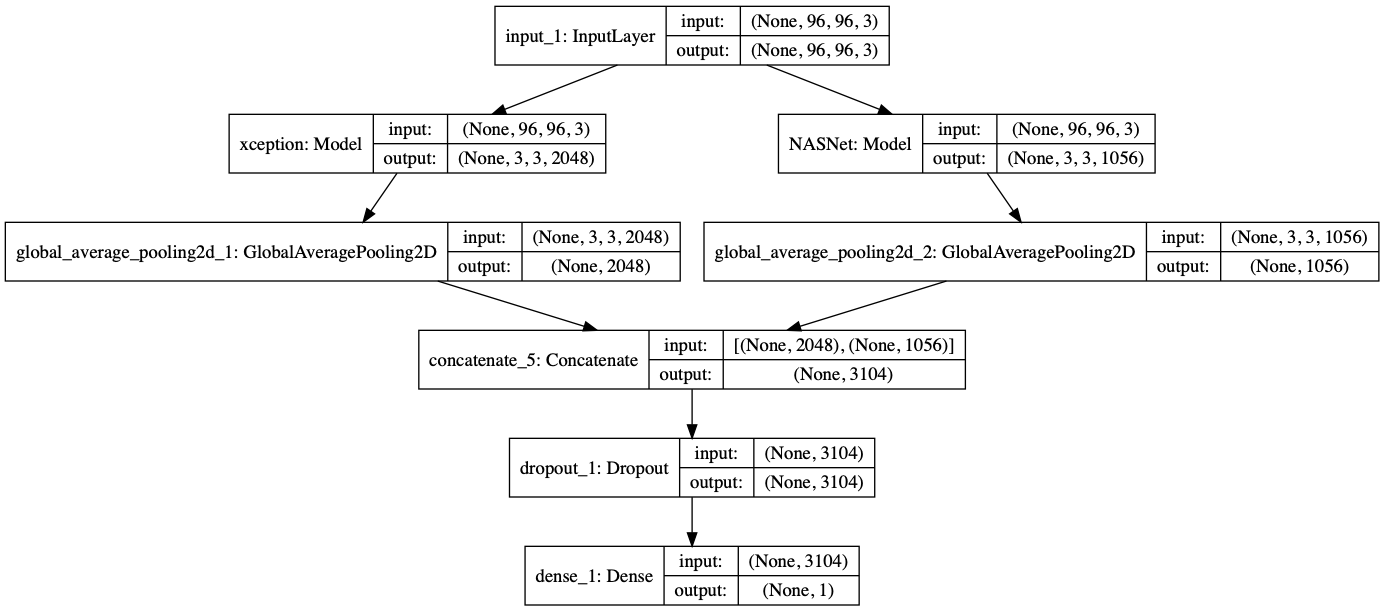

In [1]:
from IPython.display import Image, display

display(Image(filename='model_plot.png'))


In [8]:
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

xception = Xception(include_top=False, input_shape=input_shape)(inputs)

# nas_net = NASNetMobile(include_top=False, input_shape=input_shape)(inputs)

input_tensor = Input(shape=(96,96,3))
nas_net = NASNetMobile(input_tensor=input_tensor, include_top=False, weights='imagenet')(inputs)

outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(xception), GlobalAveragePooling2D()(nas_net)])
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

plot_model(model,
           to_file=MODEL_PLOT_FILE,
           show_shapes=True,
           show_layer_names=True)

c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 3, 3,      │ 20,861,480 │ input_layer[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nasnet_mobile       │ (None, 3, 3,      │  4,269,716 │ input_layer[0][0] │
│ (Functional)        │ 1056)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ xception[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1056)      │          0 │ nasnet_mobile[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 3104)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3104)      │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      3,105 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,134,301 (95.88 MB)

 Trainable params: 25,043,035 (95.53 MB)

 Non-trainable params: 91,266 (356.51 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


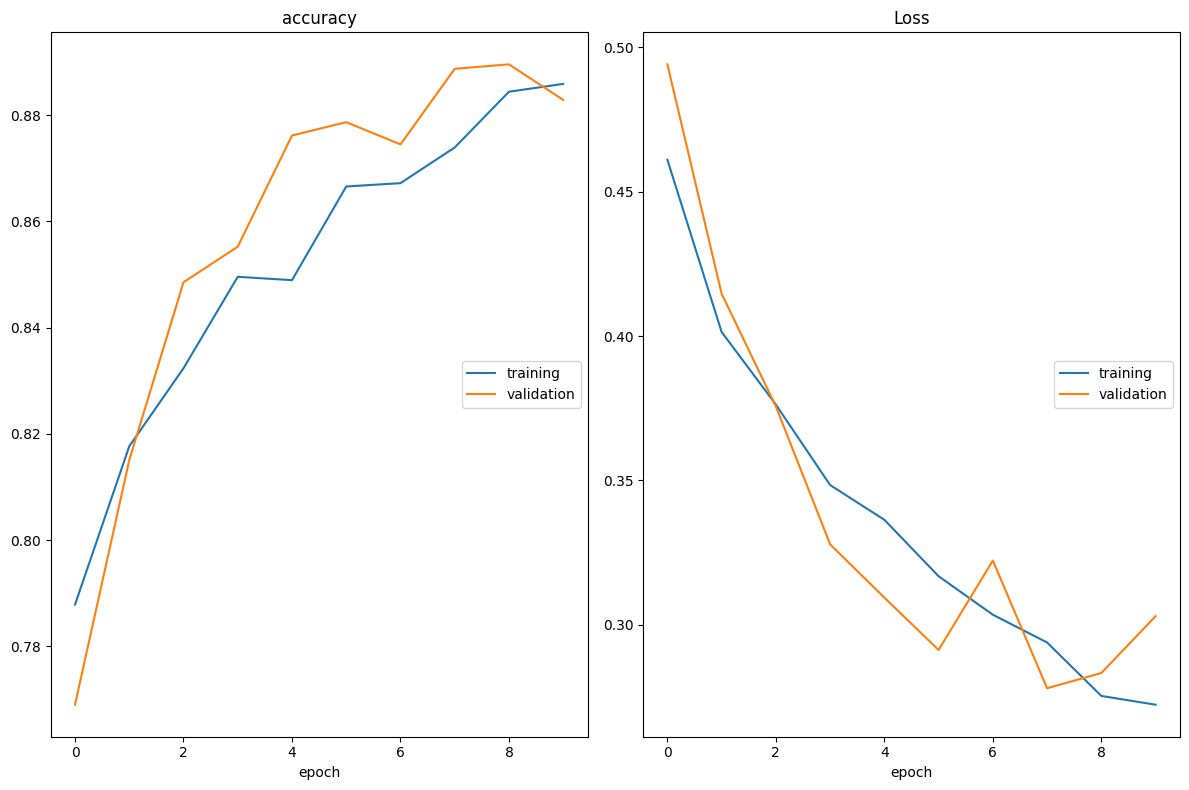

accuracy
	training         	 (min:    0.788, max:    0.886, cur:    0.886)
	validation       	 (min:    0.769, max:    0.890, cur:    0.883)
Loss
	training         	 (min:    0.272, max:    0.461, cur:    0.272)
	validation       	 (min:    0.278, max:    0.494, cur:    0.303)

Epoch 10: val_accuracy did not improve from 0.88954
25/25 ━━━━━━━━━━━━━━━━━━━━ 475s 19s/step - accuracy: 0.8843 - loss: 0.2761 - val_accuracy: 0.8828 - val_loss: 0.3030


In [10]:
#  Training
history = model.fit(
                              training_generator,
                              steps_per_epoch=len(training_generator), 
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              epochs=EPOCHS,
                              verbose=VERBOSITY,
                              callbacks=[PlotLossesKeras(),
                                         ModelCheckpoint(filepath="model.keras",
                                                         monitor='val_accuracy',
                                                         verbose=VERBOSITY,
                                                         save_best_only=True,
                                                         mode='max'
                                                        ),
                                         CSVLogger(TRAINING_LOGS_FILE,
                                                   append=False,
                                                   separator=';')])

In [12]:
epochs = [i for i in range(1, len(history.history['loss']) + 1)]

# Plot training and validation loss
plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(TRAINING_PLOT_FILE, bbox_inches='tight')
plt.close()

# Plot training and validation accuracy
plt.plot(epochs, history.history['accuracy'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_accuracy'], color='red', label="validation_accuracy")
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig(VALIDATION_PLOT_FILE, bbox_inches='tight')
plt.close()


In [16]:
# ROC testing plot
model.load_weights(MODEL_FILE)
predictions = model.predict(testing_generator, verbose=VERBOSITY)
false_positive_rate, true_positive_rate, threshold = roc_curve(testing_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_134']
Received: inputs=Tensor(shape=(192, 96, 96, 3))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step


In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8827 - loss: 0.3068
Validation Loss: 0.2833561301231384
Validation Accuracy: 88.95%


## Sample Test Evaluation Using the best Performed model

Found 1592 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


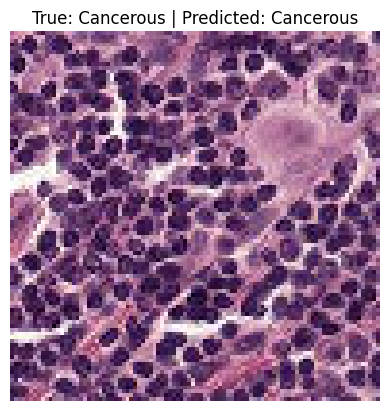

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


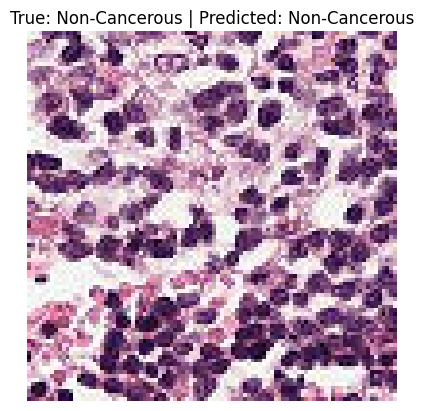

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


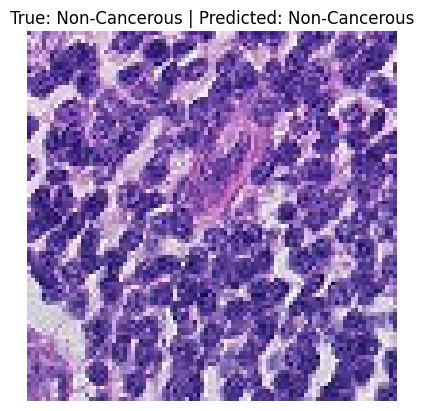

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


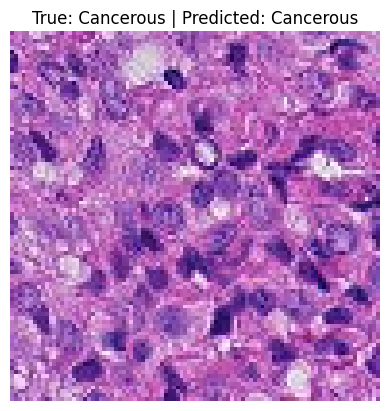

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


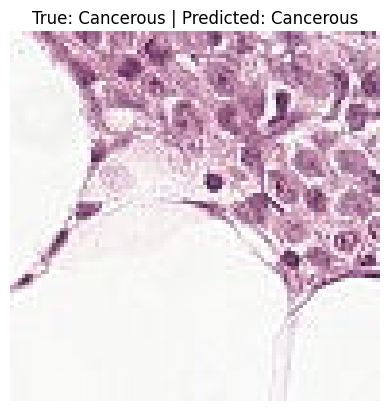

In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved model
model_path = 'model.keras'
model = load_model(model_path)

# Prepare the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale images to [0, 1]

# Load test data from directory
test_set = test_datagen.flow_from_directory(
    'validation',
    target_size=(96, 96),
    batch_size=1,
    class_mode='binary',
    shuffle=True
)

def visualize_predictions(generator, model, num_samples=5):
    generator.reset()  # Reset the generator to start from the first batch
    for i in range(num_samples):
        image, label = next(generator)  # Use next() to retrieve a batch
        prediction = (model.predict(image) > 0.5).astype('int32')
        
        plt.imshow(image[0])  # Display the first image in the batch
        true_label = 'Cancerous' if label[0] == 1 else 'Non-Cancerous'
        predicted_label = 'Cancerous' if prediction[0][0] == 1 else 'Non-Cancerous'
        
        plt.title(f"True: {true_label} | Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

# Visualize predictions on a few samples from the test set
visualize_predictions(test_set, model, num_samples=5)


Found 1592 images belonging to 2 classes.
   1/1592 ━━━━━━━━━━━━━━━━━━━━ 2:03 78ms/step

c:\Users\SoftLaptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1592/1592 ━━━━━━━━━━━━━━━━━━━━ 109s 69ms/step


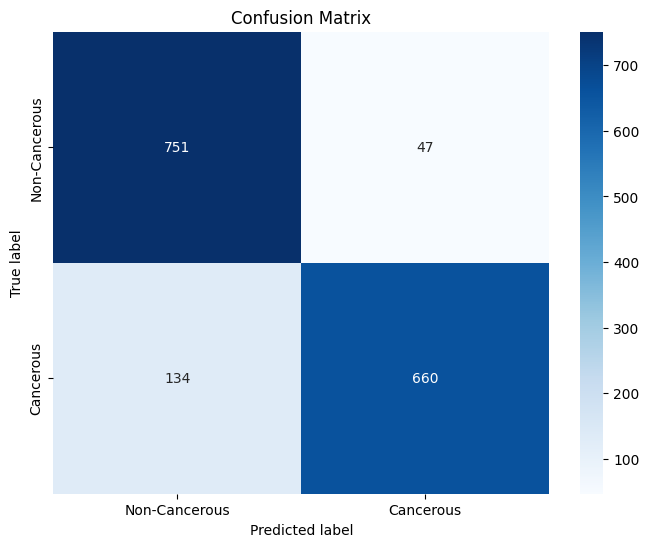

               precision    recall  f1-score   support

Non-Cancerous       0.85      0.94      0.89       798
    Cancerous       0.93      0.83      0.88       794

     accuracy                           0.89      1592
    macro avg       0.89      0.89      0.89      1592
 weighted avg       0.89      0.89      0.89      1592



In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Prepare the test data generator (if not already prepared)
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale images to [0, 1]

test_set = test_datagen.flow_from_directory(
    'validation', 
    target_size=(96, 96),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Get true labels and predictions
true_labels = test_set.classes  # True labels from the test set
predictions = (model.predict(test_set) > 0.5).astype('int32')  # Predictions from the model

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Cancerous', 'Cancerous'], 
            yticklabels=['Non-Cancerous', 'Cancerous'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_labels, predictions, target_names=['Non-Cancerous', 'Cancerous']))


## Conclusion

### Best Model: Concatenated Pretrained Models
    For Positive class(Non-Cancerous): 
        - Accuracy = 89%
        - precision: 85%
        - Recall: 94%
        - f1-score: 89%
    
    For Negative class(Cancerous): 
        - Accuracy = 89%
        - precision: 93%
        - Recall: 83%
        - f1-score: 88%


### Key Observations:

    - High True Positives (TP = 660): The model correctly identifies a significant number of actual cancer cases. This indicates good sensitivity (recall) for the "Cancerous" class.

    - High True Negatives (TN = 751): The model also effectively identifies a large number of non-cancerous cases, showing high specificity.

    - Low False Positives (FP = 47): The number of false positives is relatively low, meaning the model doesn't often misclassify non-cancerous cases as cancerous.

    - Moderate False Negatives (FN = 134): While the number of false negatives is not extremely high, it's still a concern in a medical context. False negatives can lead to missed diagnoses and delayed treatment.